<h1><center>Ising Model<center><h1>

<center>Lois Fernández Míguez<center>

# Introduction

The Ising Model is described by its Hamiltonian, which can be written as:

$$H=-J\sum_{<ij>}S_iS_j$$

Where:
 - The spins $S_i,\ S_j$ can take values $\pm1$
 - $\left\langle ij \right\rangle$ implies nearest-neighbor (*nn*) interaction only
 - $J$ is caracteristic of the material.
     - $J>0$ are ferromagnetic materials
     - $J<0$ are antiferromagnetic materials

For 1D it is proved that, in the *nn* aproximation, there are not phase transitions.

However, for a 2D Lattice it is well known that there is a phase transition at the critical temperature $T_c$ (or the critical coldness $\beta_c$). If the temperature of the system is being reduced it goes under a second order transition from an ordered state to a disordered one.

The order parameter for this system is the average magnetization

$$m=\frac{\left\langle S \right\rangle}{N}$$

 - When in the disordered state, $m=0$, showing a lack of correlation between the spins.
 - When in the ordered state, and if $J>0$ $m\neq 0$, because every spin want to adopt the same behaviour as its neighbours
 - When in the ordered state, but if $J<0$ $m=0$, since every spin want to adopt the opposite behavious as its neighbours, leading to a sum of zero in the magnetization

Even though both the Ising model in 1D and 2D can be solved analitically, these problems are specially fit for being solved by MonteCarlo (MC) simulations

In this notebook the in-depth study of the 2D Ising Model and the phase transitions of a ferromagnetic material of $J=1$ using different methods of MC Simulations will be performed

# Necessary Libraries

For this notebook to work the following libraries are needed:
 - numpy
 - scipy
 - matplotlib
 - ffmpeg

It is usual (at least for physicist) to have the first 3. However the reader may need to install ffmpeg. If you are using Anaconda you can install it by opening your prompt and using the command:

*conda install -c conda-forge ffmpeg*

Or, alternatively, if you use are using an environment with pip

*pip install ffmpeg-python*

Now let's import all the necesary libraries

In [1]:
#from __future__ import division
import numpy                as np
import matplotlib.pyplot    as plt
import matplotlib.animation as animation

from numpy.random           import rand
from scipy.sparse           import spdiags, linalg, eye
from matplotlib             import rc
from IPython.display        import HTML
rc('animation', html='html5')

# Metropolis-Hastings Algorithm

## Function Definition and Global Parameters

Let's begin by introducing the functions neccesary for the following code

First let's create a method that generates a lattice with its spins arranged randomly

In [2]:
def initialstateR(N):   
    ''' generates a random spin configuration for initial condition'''
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

We implement the Metropolis-Hastings algorithm as well. The algorithm goes as it follows:
 - Given an initial configuration of $N$ spins, flip one spin $S$ at random
 - Calculate the change in energy $\Delta E$, given by $\Delta E=2S_i\sum{S_j}$
    - If $\Delta E<0$ you accept the move
    - If $\Delta E>0$ you throw a random number between 0 and 1
         - If the number is below the probability $P(\Delta E,\beta)=e^{-\beta \Delta E}$ you accept the change

With this algorithm you are assured to satisfy the detailed balance condition, achieving a final equilibrium state

In [3]:
def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N)
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                cost = 2*s*nb
                if cost < 0:
                    s *= -1
                elif rand() < np.exp(-cost*beta):
                    s *= -1
                config[a, b] = s
    return config

We may also want to calculate macroscopic quantities and his dependance with temperature such as
 - Energy, $E\left(T\right)$
 - Magnetization, $m\left(T\right)$
 - Specific Heat, $c\left(T\right)$
 - Magnetic Susceptibility, $\chi\left(T\right)$

To do this we only need functions to calculate Energy:

In [4]:
def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/4.

And Magnetization

In [5]:
def calcMag(config):
    '''Magnetization of a given configuration'''
    mag = np.sum(config)
    return mag

We end by defining a set of global variables that our system will use

In [6]:
## change these parameters for a smaller (faster) simulation 
nt      = 88         #  number of temperature points
N       = 16         #  size of the lattice, N x N
eqSteps = 1024       #  number of MC sweeps for equilibration
mcSteps = 1024       #  number of MC sweeps for calculation
tf      = 512        #  number of steps(frames) taken for the animation
beta_eq = 0.8        #  Basis Temperature at which we do the animations
T       = np.linspace(1.53, 3.28, nt); 
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2  = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)

# divide by number of samples, and by system size to get intensive values

## Macroscopic Variables

Let us start by calculating the macroscopic variables and its dependance with Temperature to understand better this transition. This variables are defined as

$$\begin{cases}
E & =\sum S_{i}S_{j}\\
M & =\sum_{i}S_{i}\\
c & =\frac{\partial^{2}E}{\partial T^{2}}=\frac{\left\langle E^{2}\right\rangle -\left\langle E\right\rangle ^{2}}{T^{2}}\\
\chi & =\frac{1}{T}\left.\frac{\partial M}{\partial h}\right|_{h=0}=\frac{\left\langle M^{2}\right\rangle -\left\langle M\right\rangle }{T}
\end{cases}$$

For this task we need to create an initial random lattice, evolve it until it reaches equilibrium and then increase the temperature on each step.

In [7]:
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstateR(N)
    iT=1.0/T[tt]; iT2=iT*iT;
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    for i in range(mcSteps):
        mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT

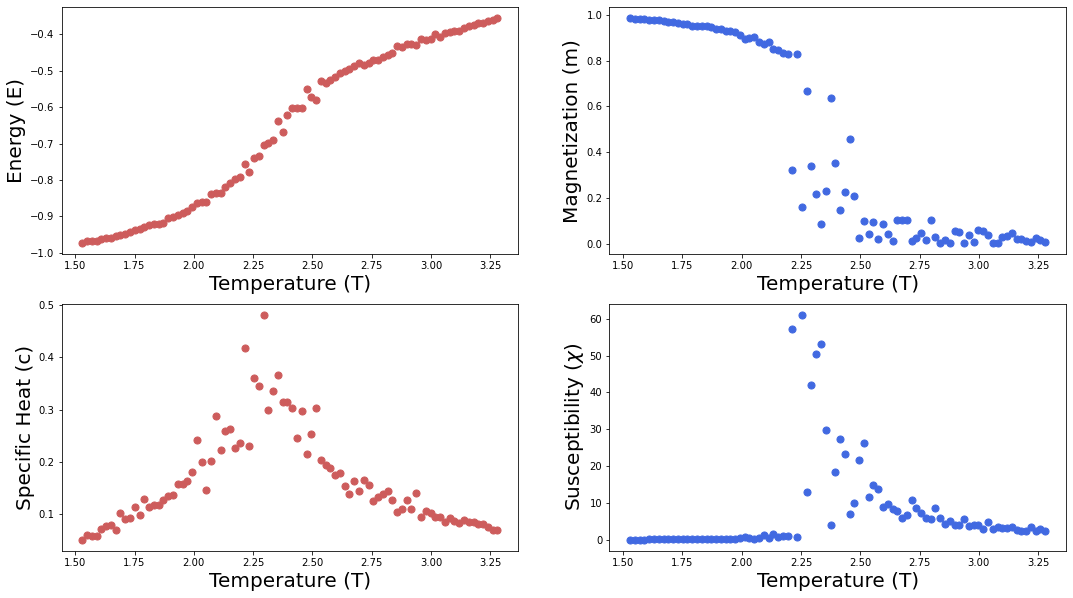

In [8]:
f = plt.figure(figsize=(18, 10)); # plot the calculated values    

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy (E)", fontsize=20);         plt.axis('tight');

sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization (m)", fontsize=20);   plt.axis('tight');

sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat (c)", fontsize=20);   plt.axis('tight');   

sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility ($\chi$)", fontsize=20);   plt.axis('tight');

We see quite what we expected from what is known of 2nd order transitions [5,6].

The Energy verifies the equation 


$$dE=pdV-TdS$$


but in our case we have no change of volume so we got a very similar curve as the known Entropy Curve of 2nd phase transitions

The Magnetization Curve is well known as well, if we remember its the order parameter of this system and it is exactly as theory predicts

The specific heat curve and magnetic susceptibility are well known as well: Two asymptotes at $T_c$. In the case of magnetic susceptibility this let us peak at a Curie-Weiss Law behaviour as Landau predicted

## Temporal Evolution of the System

To study temporal evolution of the System, we are going to begin with a configuration of a random lattice of $N$x$N$ spins with $N$

In [9]:
N = 64

and study how does the system evolve in each step towards equilibrium.

Let us begin by defining where the animation is going to be drawn and the array where the frames are going to be saved and initialize the lattice

We shall also move the system according to the Metropolis-Hastings algorithm and record every step in the array for future animation

In [10]:
fig, ax=plt.subplots()
plt.axis('off')
ims=[]
config=initialstateR(N)

for i in range(tf):
    mcmove(config,beta_eq)
    im=plt.imshow(config, cmap=plt.cm.bwr)
    title = ax.text(0.5,1.05,
                    "Metropolis-Hastings Ising at t= {} s".format(i), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im, title])
plt.close()

And now we animate our output to see how the system evolves!

In [11]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)
ani

In the animation it can be appreciated the trend of the spins to copy their neighbours behaviour. However some fluctuations can be appreciated temporally in some locations. This is due to how the Metropolis-Hastings algorithm works: The changes are purely random and don't follow the dynamics of the system.

## Thermical Evolution of the System

The objective now is to evolve the system towards an stable configuration and then, every step, change temperature to see how does it affects the system

Let us begin by leading the system towards a stable configuration

In [12]:
t_est = 350

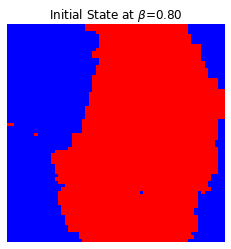

In [13]:
fig, ax=plt.subplots()
plt.axis('off')
config=initialstateR(N)
ims=[]
for i in range(t_est):
    mcmove(config,beta_eq)
im=plt.imshow(config, cmap=plt.cm.bwr)
plt.title(r'Initial State at $\beta$=%.2f'%beta_eq);

Now we evolve the system changing its temperature in each step and saving them for its future representation

In [14]:
fig, ax=plt.subplots()
plt.axis('off')
ims=[]
beta_inf=int(np.round(beta_eq/0.01))
for i in range(1,beta_inf):
    new_beta=beta_eq-0.01*i
    mcmove(config,new_beta)
    beta_title='%.2f'%new_beta
    im=plt.imshow(config, cmap=plt.cm.bwr)
    title = ax.text(0.5,1.05,r"Metropolis-Hastings Ising at $\beta$= {} ".format(beta_title), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im, title])
plt.close()

Now we animate it! Let's see what happens!

In [15]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)
ani

In the animation we can appreciate that as temperature increases ($\beta$ decreases) disorder increases as well.
What happens is this trials of the algorithm survive longer as temperatures increases. However a clear phase transition cannot be seen: It looks more like a constant ratio of change towards the new phase

# Kinetic MonteCarlo (KMC)

We see that we have an inherent problem with the Metropolis-Hastings algorithm: Even thought their predictions of the macroscopic thermodinamic and magnetic properties are accurate, the simulation can't (or at least it's hard to appreciate) a proper phase transition, it evolves too smoothly.

To solve that problem we will try a Kinetic MonteCarlo Simulation (KMC).

The idea behind KMC is to evolve the system not by random, which is what the Metropolis-Hastings algorithm does, but by following the dynamics of the system.

This means that we need to know the probability of any given state of the system to change to the new one. This is usually determined experimentally or by Molecular Dynamics Simulations. Fortunately enough, we can make a quite good educated guess on the 2D Ising model due to its simmetries

Let us have a spin up (represented by the red color) In a 2D Ising Lattice the possible combinations of first neighbours will be as it follows

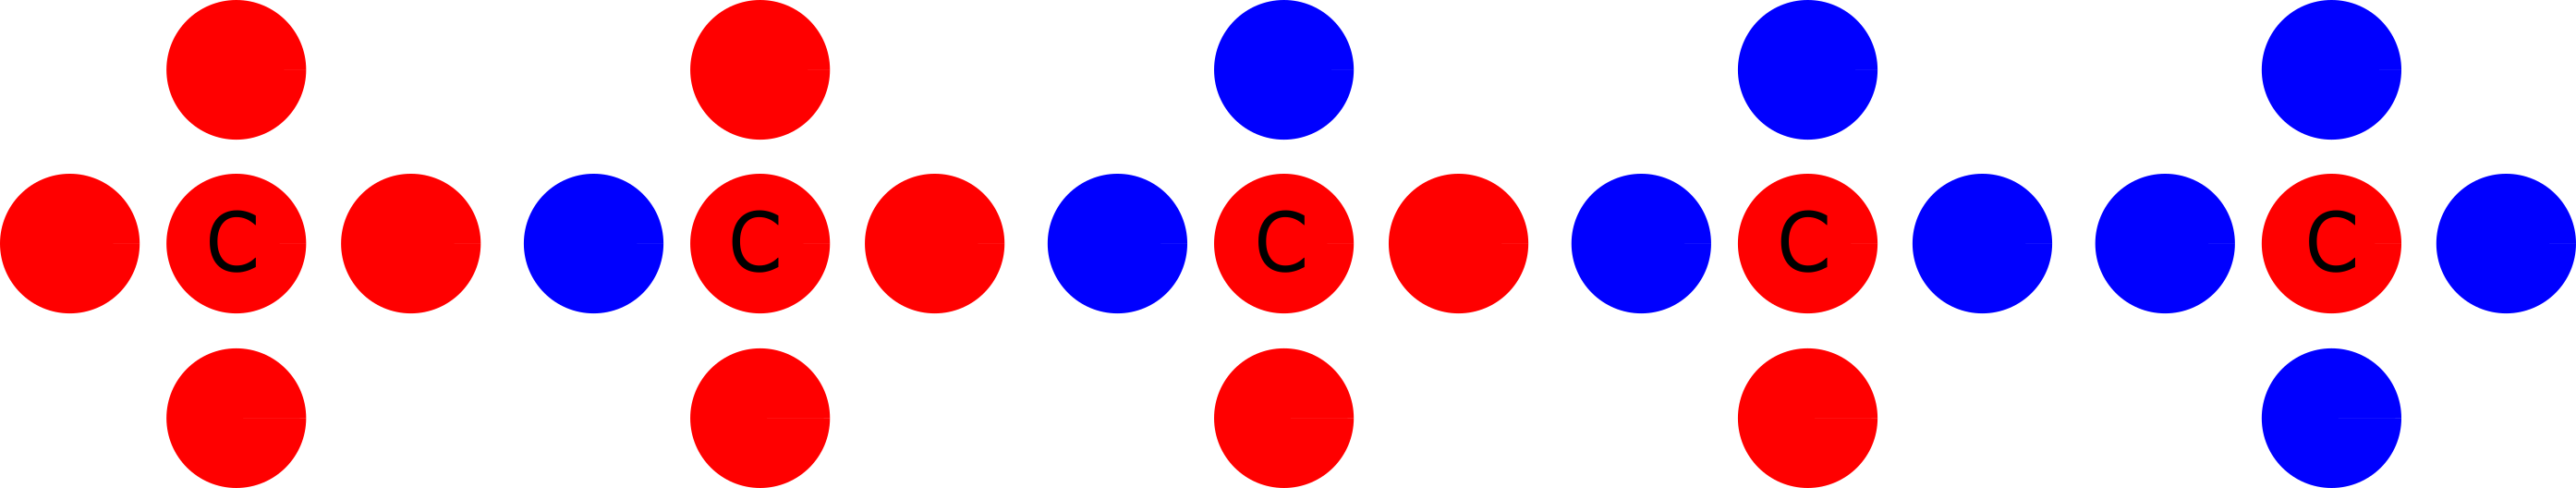

Any other possible representation is mathematically identical at one of the above. One could argue that the probabilities of the *all up* neighbours combination to switch is minimal.
By the same reasoning, the probabilities of the *all down* combination to switch is maximal.
And the probability of the *2 up 2 down* combination has to be in between.

A score directly related to the probability of this transitions to happen can be defined and it has to verify that if the spin of the center switch the score switches as well. This score is proportional to the *transition rates*

Let's define the transition probabilities of the system and, to consider the effect of the temperature we do it by puting the score into the canonic ensemble probability

$$P(\beta)=\frac{1}{Z}e^{\ \beta\cdot\ Score}$$

Keeping that in mind we define a function that follows the following algorithm
1. Begin in t=0
2. The transit to another state (up to down or viceversa) and the transition probability is given by the score. We put the score in the canonic ensemble to account for temperature
3. Create a random number between 0 and 1 that determines if we transit or not to the state.
4. Repeat 2 and 3 as long as we want the simulation running

In [26]:
def kmcmove(config, beta):
    '''Monte Carlo move using KMC algorithm '''
    Z=np.exp(4*beta)+np.exp(3*beta)+np.exp(2*beta)+np.exp(1*beta)+np.exp(0*beta)    
    for i in range(N):
        for j in range(N):
                a = np.random.randint(0, N)
                b = np.random.randint(0, N) 
                s =  config[a, b]
                nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                

                prob=np.exp(beta*(s*nb+4))/Z # We obtain a uniform distribution that account the effect of the neighbours and
                                             # the effect of temperature
                rn=rand()
                if rn>prob:
                    s *=-1
                config[a, b]=s
    return config

## Temporal Evolution

The procedure is identical at the one in the Metropolis-Hastings Section

In [32]:
fig, ax=plt.subplots()
plt.axis('off')
config=initialstateR(N)
ims=[]
t=0
for i in range(tf):
    kmcmove(config,beta_eq)
    im=plt.imshow(config, cmap=plt.cm.bwr)
    t+=np.log(1/rand())
    tp=round(t,2)
    title = ax.text(0.5,1.05,"KMC Ising at t= {} s".format(tp), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im, title])
plt.close()

In [33]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)
ani

We see that there is no more *trial and error* in the evolution of the system: Every spin goes towards the new states with a given probability

## Thermal Evolution

The procedure is still identical at the one of Metropolis-Hastings

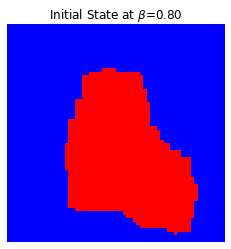

In [19]:
fig, ax=plt.subplots()
plt.axis('off')
config=initialstateR(N)
ims=[]
for i in range(t_est):
    kmcmove(config,beta_eq)
im=plt.imshow(config, cmap=plt.cm.bwr)
plt.title(r'Initial State at $\beta$=%.2f'%beta_eq);

In [20]:
fig, ax=plt.subplots()
plt.axis('off')
ims=[]
beta_inf=int(np.round(beta_eq/0.01))
for i in range(1,beta_inf):
    new_beta=beta_eq-0.01*i
    kmcmove(config,new_beta)
    beta_title='%.2f'%new_beta
    im=plt.imshow(config, cmap=plt.cm.bwr)
    title = ax.text(0.5,1.05,r"Malla para $\beta$= {} ".format(beta_title), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im, title])
plt.close()

In [21]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)
ani

The phase transition is more clear and realistic: It has a constant behaviour until the critical temperature is reached. Then the system evolves rapidly to the new stable configuration

# Quantum Kinetic MonteCarlo

To model a quantum Ising-like behaviour we need a system that follows a series of properties:
 - The system has to describe a second order transition
 - Instead of a set of spins (up or down), the object of study will be a probability density
 - The system has to evolve with time

Fortunately enough, the Ginzburg-Landau equation is a well known equation that studies second order transitions of a probability density.

Let's use a Time Dependant Ginzburg-Landau Equation (TDGL) then! 

The equation of motion for the probability density $\phi$ can be written as:

$$\frac{\partial\phi}{\partial t}=-\Gamma\frac{\partial F}{\partial \phi}+\theta\left(\vec{r},t\right)$$

Where $F\left(\phi\right)$ is the free-energy functional 

$$F(\phi)=\int\left[a\phi^2+b\phi^4+\frac{1}{2}K\left(\nabla\phi\right)^2\right]$$



For $T<T_c$ we can write TDGL in terms of rescaled variables as

$$\frac{\partial\phi}{\partial t}=\phi-\phi^3+\nabla^2\phi$$

Unfortunately, since this approximation is only valid under the $T_c$, we cannot study the Thermal Evolution with those equations

Now that the theory is clear lets implement some constants that we will need to solve this system

## Function Definition and Global Parameters

In [22]:
a,b, k = 0, 1.0, 100.0 #GL Parameters
dh, dt = 1.0, 1e-3     #Steps of integration      

We implement the necessary funtions for this to work

In [23]:
def mu(u):
    return a*u + b*u*u*u 

def laplacian(Ng):
    '''Construct a sparse matrix that applies the 5-point Laplacian discretization'''
    e=np.ones(Ng**2)
    e2=([1]*(Ng-1)+[0])*Ng
    e3=([0]+[1]*(Ng-1))*Ng
    h=dh
    A=spdiags([-4*e,e2,e3,e,e],[0,-1,1,-Ng,Ng],Ng**2,Ng**2)
    A/=h**2
    return A
     
def configPlot(x, y, u, i):
    U= u.reshape((N, N))
    im=plt.imshow(U, cmap=plt.cm.bwr);
    return im

## Temporal Evolution

Now with everything built, it's time to simulate! We will be solving and saving the state of each step on the equation for its future representation

In [24]:
fig, ax=plt.subplots()
plt.axis('off')
x = np.linspace(-1,1,N)
y = np.linspace(-1,1,N)
X, Y = np.meshgrid(x, y)    # Create the grid

u=np.random.randn(N*N, 1);  # Initial data
L =laplacian(N)             # construct the laplacian

ims=[]
for i in range(tf):          
    u = u - dt*(mu(u) - k*L.dot(u))
    im=configPlot(x, y, u, 100)
    title = ax.text(0.5,1.05,"QKCM Ising at t= {} s".format(i), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im, title])
plt.close()

Now let's build an animation with the states we have saved

In [25]:
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
    repeat_delay=1000)
ani

In this animation the correlative behaviour caracteristic of the Ising model can be seen but with probability densities instead of either spins up or spins down.

Those spins more surrounded of spins of the same sign have a greater probability of being in the same state. On the other hand, the spins caught between the two magnetic domains have a probability closer to $\frac{1}{2}$

Long range correlations can be appreciated in the probability density, going from the most probable (which is the point or points further away of the border) towards the $\frac{1}{2}$ probability in a smooth gradient of color

# References

1. L.M. Varela, Notas de Simulación Avanzada de Materiales
2. L.M. Varela, Alfonso V. Ramallo, Notas de Mecánica Estadística I
3. Backbone of this code: https://rajeshrinet.github.io/blog/2014/ising-model/
4. Magnetic Susceptibility in Ising Model: http://cds.cern.ch/record/506582/files/0106270.pdf
5. Phase Order Transitions: https://ps.uci.edu/~cyu/p238C/LectureNotes/PhaseTransitions/PhaseTransitions.pdf
6. Landau Theory of Second Order Phase Transitions: https://lampx.tugraz.at/~hadley/ss2/landau/second_order.php
7. 5 point Laplacian discretization: https://github.com/ketch/finite-difference-course